In [336]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [337]:
# get the train and test csv
X = pd.read_csv('../input/home-data-for-ml-course/train.csv', index_col='Id')
X_test = pd.read_csv('../input/home-data-for-ml-course/test.csv', index_col='Id')

y = X.pop('SalePrice')

X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [436]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data for xgb
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [338]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [339]:
# get all the sales prices
y

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

In [340]:
# find low cardinality categorical columns
low_card_cols = [col for col in X.columns if X[col].nunique() < 15 and X[col].dtype == 'object']
low_card_cols = set(low_card_cols)
low_card_cols

{'Alley',
 'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Fence',
 'FireplaceQu',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'PavedDrive',
 'PoolQC',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities'}

In [341]:
# get the numerical columns
numerical_cols = set([col for col in X.columns if X[col].dtype in ['int64', 'float64']])
numerical_cols

{'1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold'}

In [342]:
# look at the numerical cols with garage
garage_cols = [col for col in X.columns if col.startswith('Garage')]
X[garage_cols].describe()

,GarageYrBlt,GarageCars,GarageArea
count,1379.000000,1460.000000,1460.000000
mean,1978.506164,1.767123,472.980137
std,24.689725,0.747315,213.804841
min,1900.000000,0.000000,0.000000
25%,1961.000000,1.000000,334.500000
50%,1980.000000,2.000000,480.000000
75%,2002.000000,2.000000,576.000000
max,2010.000000,4.000000,1418.000000


In [343]:
# Look at garage area
zero_area = X[X['GarageArea'] == 0]
zero_area[garage_cols].head(10)

# get the nuercial garage columns
numerical_garage = ['GarageYrBlt', 'GarageCars', 'GarageArea']

# consider: type, finishm cond, qual -> all caterogrical, many NaN

In [344]:
# get the object garabe cols and add them to many nulls (below)
obj_garage_cols = set(garage_cols) - set(numerical_garage)
print(obj_garage_cols)

{'GarageType', 'GarageFinish', 'GarageCond', 'GarageQual'}


In [345]:
# remove the year the garage was built in. The other garage info wil be enough and there are plenty of null values here
numerical_cols = list(numerical_cols - {'GarageYrBlt'})
numerical_cols

['BsmtUnfSF',
 'BsmtFinSF1',
 'BsmtHalfBath',
 'YearBuilt',
 'BsmtFullBath',
 'YrSold',
 'GarageCars',
 'LotArea',
 'BedroomAbvGr',
 'HalfBath',
 'MasVnrArea',
 'FullBath',
 'ScreenPorch',
 'MiscVal',
 'LotFrontage',
 'GrLivArea',
 '2ndFlrSF',
 'OverallQual',
 'MoSold',
 'BsmtFinSF2',
 'OverallCond',
 'GarageArea',
 'MSSubClass',
 'Fireplaces',
 'YearRemodAdd',
 'WoodDeckSF',
 'KitchenAbvGr',
 'TotalBsmtSF',
 'TotRmsAbvGrd',
 '1stFlrSF',
 'LowQualFinSF',
 '3SsnPorch',
 'OpenPorchSF',
 'EnclosedPorch',
 'PoolArea']

In [346]:
# find null columns
nulls = X.isna().sum()[X.isna().sum() > 0]
many_nulls_list = nulls[nulls > 100]
print(many_nulls_list)

"""
LotFrontage: Linear feet of street connected to property
most likely data not avaliable

Alley: Type of alley access to property
Makes sense to input as a constant value of none

FireplaceQu: Fireplace quality
Many NA fireplaces -> null

PoolQC: Pool quality
Many NA pools -> null

Fence: Fence Quality
Many NA fences- > null

MiscFeature: Miscellaneous feature not covered in other categories
Many NA (none) other features -> null

"""

LotFrontage     259
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64


'\nLotFrontage: Linear feet of street connected to property\nmost likely data not avaliable\n\nAlley: Type of alley access to property\nMakes sense to input as a constant value of none\n\nFireplaceQu: Fireplace quality\nMany NA fireplaces -> null\n\nPoolQC: Pool quality\nMany NA pools -> null\n\nFence: Fence Quality\nMany NA fences- > null\n\nMiscFeature: Miscellaneous feature not covered in other categories\nMany NA (none) other features -> null\n\n'

In [347]:
# get the set of values in columns with many unique values (the imputers and data transformers on these columns may impact results)
many_null_cols = [col for col in many_nulls_list.index]
many_null_col_vals = [set(X[col].dropna()) for col in many_null_cols]
many_nulls = dict(zip(many_null_cols, many_null_col_vals))
many_nulls

{'LotFrontage': {21.0,
  24.0,
  30.0,
  32.0,
  33.0,
  34.0,
  35.0,
  36.0,
  37.0,
  38.0,
  39.0,
  40.0,
  41.0,
  42.0,
  43.0,
  44.0,
  45.0,
  46.0,
  47.0,
  48.0,
  49.0,
  50.0,
  51.0,
  52.0,
  53.0,
  54.0,
  55.0,
  56.0,
  57.0,
  58.0,
  59.0,
  60.0,
  61.0,
  62.0,
  63.0,
  64.0,
  65.0,
  66.0,
  67.0,
  68.0,
  69.0,
  70.0,
  71.0,
  72.0,
  73.0,
  74.0,
  75.0,
  76.0,
  77.0,
  78.0,
  79.0,
  80.0,
  81.0,
  82.0,
  83.0,
  84.0,
  85.0,
  86.0,
  87.0,
  88.0,
  89.0,
  90.0,
  91.0,
  92.0,
  93.0,
  94.0,
  95.0,
  96.0,
  97.0,
  98.0,
  99.0,
  100.0,
  101.0,
  102.0,
  103.0,
  104.0,
  105.0,
  106.0,
  107.0,
  108.0,
  109.0,
  110.0,
  111.0,
  112.0,
  114.0,
  115.0,
  116.0,
  118.0,
  120.0,
  121.0,
  122.0,
  124.0,
  128.0,
  129.0,
  130.0,
  134.0,
  137.0,
  138.0,
  140.0,
  141.0,
  144.0,
  149.0,
  150.0,
  152.0,
  153.0,
  160.0,
  168.0,
  174.0,
  182.0,
  313.0},
 'Alley': {'Grvl', 'Pave'},
 'FireplaceQu': {'Ex', 'Fa', 'Gd', 'P

In [348]:
# remove the basement null cols
replace_null_cols = [col for col in low_card_cols if X[col].isna().sum() > 10]
replace_null_cols

['FireplaceQu',
 'BsmtExposure',
 'GarageType',
 'Fence',
 'BsmtFinType1',
 'PoolQC',
 'Alley',
 'GarageCond',
 'MiscFeature',
 'BsmtQual',
 'GarageFinish',
 'BsmtFinType2',
 'BsmtCond',
 'GarageQual']

In [349]:
# add the columns with many nulls to the garage categorical cols to get the final columns with many nulls to replace
# replace_null_cols = many_null_cols[1:] + list(obj_garage_cols)
# replace_null_cols 

In [350]:
# check categorical transformer for many null cols and drop
low_card_cols = list(low_card_cols - set(replace_null_cols))
low_card_cols

['Condition1',
 'HouseStyle',
 'ExterCond',
 'Street',
 'Functional',
 'RoofStyle',
 'MasVnrType',
 'LotConfig',
 'BldgType',
 'Foundation',
 'PavedDrive',
 'Condition2',
 'CentralAir',
 'LandContour',
 'LandSlope',
 'SaleCondition',
 'LotShape',
 'Utilities',
 'Electrical',
 'KitchenQual',
 'MSZoning',
 'HeatingQC',
 'ExterQual',
 'SaleType',
 'Heating',
 'RoofMatl']

In [351]:
X[low_card_cols].isna().sum()
# removed all columns that come in empty from categorical cols (all in null cols now)

Condition1       0
HouseStyle       0
ExterCond        0
Street           0
Functional       0
RoofStyle        0
MasVnrType       8
LotConfig        0
BldgType         0
Foundation       0
PavedDrive       0
Condition2       0
CentralAir       0
LandContour      0
LandSlope        0
SaleCondition    0
LotShape         0
Utilities        0
Electrical       1
KitchenQual      0
MSZoning         0
HeatingQC        0
ExterQual        0
SaleType         0
Heating          0
RoofMatl         0
dtype: int64

In [352]:
# explore the columns that start with lot to see if lot frontage can be removed
lots = [col for col in X.columns if col.startswith('Lot')]
lot_df = X[lots].sort_values(by='LotFrontage', ascending=False)
lot_df.head(20)

,LotFrontage,LotArea,LotShape,LotConfig
Id,,,,
1299,313.0,63887,IR3,Corner
935,313.0,27650,IR2,Inside
1128,182.0,14572,IR3,Corner
232,174.0,15138,IR1,Inside
198,174.0,25419,Reg,Corner
1108,168.0,23257,IR3,CulDSac
1183,160.0,15623,IR1,Corner
1338,153.0,4118,IR1,Corner
1212,152.0,12134,IR1,Inside


Text(0.5, 1.0, 'Lot frontage vs area')

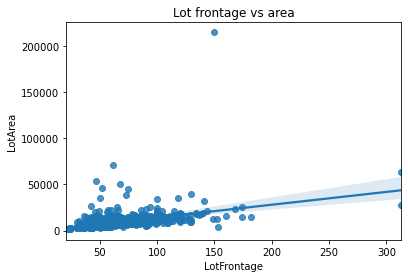

In [353]:
# plot lot frontage vs lot area
import seaborn as sns
ax = sns.regplot(x=lot_df['LotFrontage'], y=lot_df['LotArea'])
ax.set_title('Lot frontage vs area')

In [354]:
# calculate pearson correlation
pearsoncorr = lot_df.corr(method='pearson')
pearsoncorr

# consider dropping lot frontage since there is moderate correlation with lot area

,LotFrontage,LotArea
LotFrontage,1.000000,0.426095
LotArea,0.426095,1.000000


In [438]:
# change the feature data to only include the columns for low cardinality categorical columns and numbers
X_clean = X[numerical_cols + low_card_cols + replace_null_cols].copy()
X_test_clean = X_test[numerical_cols + low_card_cols + replace_null_cols].copy()
X_train = X_train_full[numerical_cols + low_card_cols + replace_null_cols].copy()
X_valid = X_valid_full[numerical_cols + low_card_cols + replace_null_cols].copy()
X_clean.head()

,BsmtUnfSF,BsmtFinSF1,BsmtHalfBath,YearBuilt,BsmtFullBath,YrSold,GarageCars,LotArea,BedroomAbvGr,HalfBath,...,BsmtFinType1,PoolQC,Alley,GarageCond,MiscFeature,BsmtQual,GarageFinish,BsmtFinType2,BsmtCond,GarageQual
Id,,,,,,,,,,,,,,,,,,,,,
1,150,706,0,2003,1,2008,2,8450,3,1,...,GLQ,NaN,NaN,TA,NaN,Gd,RFn,Unf,TA,TA
2,284,978,1,1976,0,2007,2,9600,3,0,...,ALQ,NaN,NaN,TA,NaN,Gd,RFn,Unf,TA,TA
3,434,486,0,2001,1,2008,2,11250,3,1,...,GLQ,NaN,NaN,TA,NaN,Gd,RFn,Unf,TA,TA
4,540,216,0,1915,1,2006,3,9550,3,0,...,ALQ,NaN,NaN,TA,NaN,TA,Unf,Unf,Gd,TA
5,490,655,0,2000,1,2008,3,14260,4,1,...,GLQ,NaN,NaN,TA,NaN,Gd,RFn,Unf,TA,TA


In [448]:
print(X_valid.shape, X_train.shape)

(292, 75) (1168, 75)


In [356]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error

# deal with numerical cols
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# deal with columns that have many null values
many_null_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# deal with categorical columns. Test two strategies for the imputer
categorical_transformer_1 = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_1 = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer_1, low_card_cols+replace_null_cols)
    ])

# ('many_null', many_null_transformer, replace_null_cols)

In [465]:
from sklearn.model_selection import cross_val_score
from typing import Union
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

def test_model(model: Union[RandomForestRegressor, xgb.XGBRegressor], preprocesser: ColumnTransformer) -> float:
    # create the pipeline for the model
    model_pipeline = Pipeline(steps = [
        ('preprocess', preprocesser),
        ('model', model)
    ])
    
    # check if xg boost is being used
    if type(model) != RandomForestRegressor:
        # fit the eval set before passing it to fit params
        X_val_eval = X_valid.copy()
        # add only preprocessor to the pipeline to process the X_val_eval
        eval_pipeline = Pipeline(steps = [('preprocess', preprocesser)])
        # fit the eval set to this new pipeline
        X_val_eval = pd.DataFrame(eval_pipeline.fit(X_train).transform(X_val_eval))
        
        X_val_eval.columns = [f'f{col}' for col in X_val_eval.columns]
        print(X_val_eval)
        
        fit_params={'model__early_stopping_rounds': 20, 
            'model__eval_metric': 'mae',
            'model__verbose': True,
            'model__eval_set': [[X_val_eval, y_valid]]}
        
        # use cross validation on 80:20 splits to check model accuracy using test train split data for xgb
        scores = -1 * cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', fit_params=fit_params)
    else:
        # use cross validation on 80:20 splits to check model accuracy using all data
        scores = -1 * cross_val_score(model_pipeline, X_clean, y, cv=5, scoring='neg_mean_absolute_error')
    
    return scores.mean()

test_model(xgb.XGBRegressor(n_estimators=5), preprocessor_1)

          0         1    2         3    4    5    6         7    8    9    \
0    0.571796  1.172486  0.0 -0.324324  1.0 -0.5  0.0  5.771560  1.0  0.0   
1   -0.419203  0.032821  0.0 -0.670270  1.0 -1.0 -1.0 -0.005608  0.0  0.0   
2    0.071153 -0.271648  0.0 -0.475676  1.0  0.5 -1.0 -0.622507  0.0  0.0   
3    0.489498  0.017458  0.0  0.108108  0.0  0.0  0.0  0.122757  1.0  1.0   
4    0.072868 -0.530028  0.0 -0.021622  0.0  1.0 -1.0 -1.952268  0.0  1.0   
..        ...       ...  ...       ...  ...  ...  ...       ...  ...  ...   
287 -0.655808  1.731145  0.0  0.454054  2.0  0.0  0.0  0.332378 -2.0  1.0   
288  0.523789  1.937849  0.0  0.778378  1.0  0.5  1.0  1.475199 -1.0  0.0   
289 -0.827261 -0.295391  0.0 -1.210811  0.0 -0.5 -1.0 -0.247383  2.0  0.0   
290 -0.587227 -0.138966  0.0 -0.691892  0.0  0.5 -2.0 -1.042498 -1.0  0.0   
291  0.081440 -0.530028  0.0 -1.124324  0.0 -0.5 -1.0 -0.576396  0.0  0.0   

     ...  216  217  218  219  220  221  222  223  224  225  
0    ...  1.0 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

nan

In [358]:
# create a few random forest models
model_1 = RandomForestRegressor(n_estimators=100, random_state=0)
model_2 = RandomForestRegressor(n_estimators=200, random_state=0)
model_3 = RandomForestRegressor(n_estimators=300, random_state=0)
model_4 = RandomForestRegressor(n_estimators=400, random_state=0)
model_5 = RandomForestRegressor(n_estimators=325, random_state=0)

rf_list = [model_1, model_2, model_3, model_4, model_5]
accuracy_1 = []
for model in rf_list:
    accuracy_1.append(test_model(model, preprocessor_1))

"""
Results
17582.88258904109
17545.992270547944
17532.8472283105
17562.180580479453
17559.728131506847

Run 2
17696.57582191781
17629.291688356163
17618.58353652968
17606.96818150685
17606.63126027397
"""

17668.580184931507
17595.95196232877
17533.18764611872
17550.457345890412
17548.591466807167


'\nResults\n17582.88258904109\n17545.992270547944\n17532.8472283105\n17562.180580479453\n17559.728131506847\n\nRun 2\n17696.57582191781\n17629.291688356163\n17618.58353652968\n17606.96818150685\n17606.63126027397\n'

Text(0, 0.5, 'House Price Prediction Error ($)')

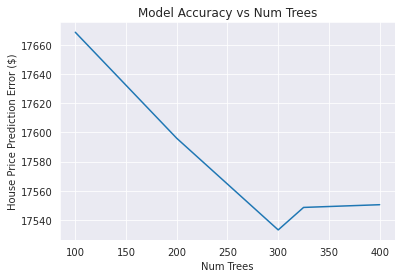

In [365]:
num_estimators = [100, 200, 300, 400, 325]
if accuracy_1 == None:
    accuracy_1 = [17668.580184931507, 17595.95196232877, 17533.18764611872, 17550.457345890412, 17548.591466807167]
# graph the estimators v accuracy
sns.set_style('darkgrid')
ax = sns.lineplot(x=num_estimators, y=accuracy_1)
ax.set_title('Model Accuracy vs Num Trees')
ax.set_xlabel('Num Trees')
ax.set_ylabel('House Price Prediction Error ($)')

In [364]:
model_6 = RandomForestRegressor(n_estimators=300, max_depth=25, random_state=0)
model_7 = RandomForestRegressor(n_estimators=300, max_depth=40, random_state=0)
model_8 = RandomForestRegressor(n_estimators=300, max_depth=60, random_state=0)


accuracy_2 = []
rf_list_2 = [model_6, model_7, model_8]
for model in rf_list_2:
    accuracy_2.append(test_model(model, preprocessor_1))
"""
Results
17552.264642781876
17545.47420156556
17573.30147162427
"""

'\nResults\n17552.264642781876\n17545.47420156556\n17573.30147162427\n'

Text(0, 0.5, 'House Price Prediction Error ($)')

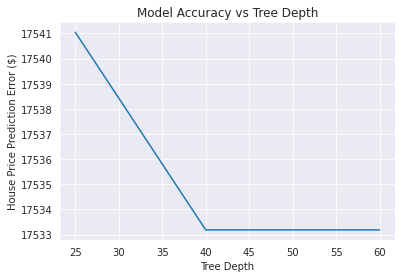

In [375]:
depth_cols = [25, 40, 60]
ax_2 = sns.lineplot(x=depth_cols, y=accuracy_2)
ax_2.set_title('Model Accuracy vs Tree Depth')
ax_2.set_xlabel('Tree Depth')
ax_2.set_ylabel('House Price Prediction Error ($)')

In [370]:
model_9 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=10, random_state=0)
model_10 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=20, random_state=0)
model_11 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=35, random_state=0)
model_12 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=50, random_state=0)


accuracy_3 = []
rf_list_3 = [model_9, model_10, model_11, model_12]
for model in rf_list_3:
    accuracy_3.append(test_model(model, preprocessor_1))

In [371]:
model_13 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features = 25, random_state=0)
accuracy_3.append(test_model(model_13, preprocessor_1))

In [381]:
model_13_2 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features = 30, random_state=0)
accuracy_3.append(test_model(model_13_2, preprocessor_1))

Text(0, 0.5, 'House Price Prediction Error ($)')

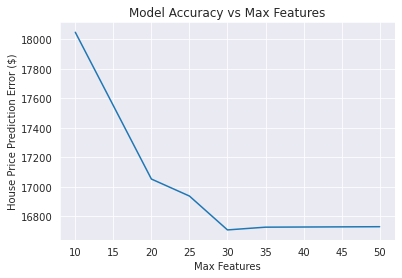

In [382]:
max_feature_vals = [10, 20, 35, 50, 25, 30]
ax_3 = sns.lineplot(x=max_feature_vals, y=accuracy_3)
ax_3.set_title('Model Accuracy vs Max Features')
ax_3.set_xlabel('Max Features')
ax_3.set_ylabel('House Price Prediction Error ($)')

In [374]:
model_14 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=30, min_samples_leaf=2, random_state=0)
model_15 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=30, min_samples_leaf=5, random_state=0)
model_16 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=30, min_samples_leaf=10, random_state=0)
model_17 = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=30, min_samples_leaf=20, random_state=0)


accuracy_4 = []
rf_list_4 = [model_14, model_15, model_16, model_17]
for model in rf_list_4:
    accuracy_4.append(test_model(model, preprocessor_1))

Text(0, 0.5, 'House Price Prediction Error ($)')

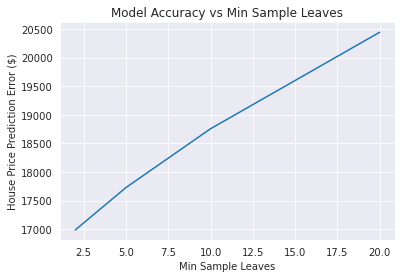

In [377]:
min_sample_leaf_vals = [2, 5, 10, 20]
ax_4 = sns.lineplot(x=min_sample_leaf_vals, y=accuracy_4)
ax_4.set_title('Model Accuracy vs Min Sample Leaves')
ax_4.set_xlabel('Min Sample Leaves')
ax_4.set_ylabel('House Price Prediction Error ($)')

In [378]:
model_18 = RandomForestRegressor(n_estimators=300, max_depth=40, min_samples_split=3, max_features=30, random_state=0)
model_19 = RandomForestRegressor(n_estimators=300, max_depth=40, min_samples_split=5, max_features=30, random_state=0)
model_20 = RandomForestRegressor(n_estimators=300, max_depth=40, min_samples_split=10, max_features=30, random_state=0)
model_21 = RandomForestRegressor(n_estimators=300, max_depth=40, min_samples_split=20, max_features=30, random_state=0)


accuracy_5 = []
rf_list_5 = [model_18, model_19, model_20, model_21]
for model in rf_list_5:
    accuracy_5.append(test_model(model, preprocessor_1))

Text(0, 0.5, 'House Price Prediction Error ($)')

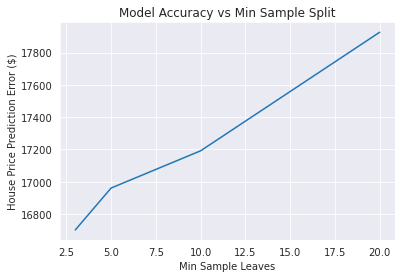

In [379]:
min_samples_split_vals = [3, 5, 10, 20]
ax_5 = sns.lineplot(x=min_samples_split_vals, y=accuracy_5)
ax_5.set_title('Model Accuracy vs Min Sample Split')
ax_5.set_xlabel('Min Sample Split')
ax_5.set_ylabel('House Price Prediction Error ($)')

In [414]:
# try out the optimal rf, keep max_features at 25 to avoid over fitting
rf_model = RandomForestRegressor(n_estimators=300, max_depth=40, max_features=25, random_state=0)
print(test_model(rf_model, preprocessor_1))

16937.826748858446


In [440]:
# create a few xgboost models
xgb_model_1 = xgb.XGBRegressor(n_estimators=100, random_state=0)
xgb_model_2 = xgb.XGBRegressor(n_estimators=300, random_state=0)
xgb_model_3 = xgb.XGBRegressor(n_estimators=500, random_state=0)
xgb_model_4 = xgb.XGBRegressor(n_estimators=700, random_state=0)
xgb_model_5 = xgb.XGBRegressor(n_estimators=1000, random_state=0)

xgb_list = [xgb_model_1, xgb_model_2, xgb_model_3, xgb_model_4, xgb_model_5]
xgb_accuracy_1 = []
for model in xgb_list:
    xgb_accuracy_1.append(test_model(model, preprocessor_1))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/core.py", line 422, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py", line 603, in fit
    callbacks=callbacks)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 235, in train
    early_stopping_rounds=early_stopping_rounds)
  File "/opt/conda/lib/python3.7/site-packages/xgboost/training.py", line 54, in _t

Text(0, 0.5, 'House Price Prediction Error ($)')

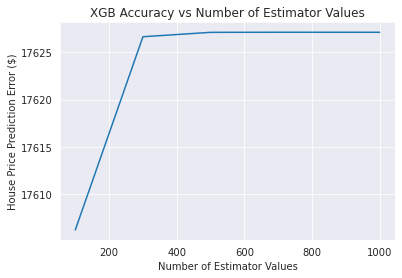

In [421]:
num_estimator_vals = [100, 300, 500, 700, 1000]
ax_6 = sns.lineplot(x=num_estimator_vals, y=xgb_accuracy_1)
ax_6.set_title('XGB Accuracy vs Number of Estimator Values')
ax_6.set_xlabel('Number of Estimator Values')
ax_6.set_ylabel('House Price Prediction Error ($)')

In [422]:
# more xgb models with a lower n estimators
xgb_model_6 = xgb.XGBRegressor(n_estimators=10, random_state=0)
xgb_model_7 = xgb.XGBRegressor(n_estimators=25, random_state=0)
xgb_model_8 = xgb.XGBRegressor(n_estimators=35, random_state=0)
xgb_model_9 = xgb.XGBRegressor(n_estimators=55, random_state=0)
xgb_model_10 = xgb.XGBRegressor(n_estimators=75, random_state=0)
xgb_model_11 = xgb.XGBRegressor(n_estimators=20, random_state=0)
xgb_model_12 = xgb.XGBRegressor(n_estimators=15, random_state=0)

xgb_list_2 = [xgb_model_6, xgb_model_7, xgb_model_8, xgb_model_9, xgb_model_10, xgb_model_11, xgb_model_12]
xgb_accuracy_2 = []
for model in xgb_list_2:
    xgb_accuracy_2.append(test_model(model, preprocessor_1))

Text(0, 0.5, 'House Price Prediction Error ($)')

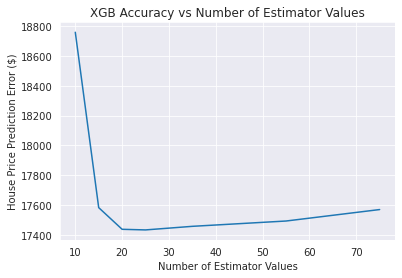

In [423]:
num_estimator_vals = [10, 25, 35, 55, 75, 20, 15]
ax_7 = sns.lineplot(x=num_estimator_vals, y=xgb_accuracy_2)
ax_7.set_title('XGB Accuracy vs Number of Estimator Values')
ax_7.set_xlabel('Number of Estimator Values')
ax_7.set_ylabel('House Price Prediction Error ($)')

In [424]:
# change the learning rate to increase model accuracy
xgb_model_13 = xgb.XGBRegressor(n_estimators=20, learning_rate=0.2, random_state=0)
xgb_model_14 = xgb.XGBRegressor(n_estimators=20, learning_rate=0.1, random_state=0)
xgb_model_15 = xgb.XGBRegressor(n_estimators=20, learning_rate=0.05, random_state=0)
xgb_model_16 = xgb.XGBRegressor(n_estimators=20, learning_rate=0.01, random_state=0)
xgb_model_17 = xgb.XGBRegressor(n_estimators=20, learning_rate=0.008, random_state=0)

xgb_list_4 = [xgb_model_13, xgb_model_14, xgb_model_15, xgb_model_16, xgb_model_17]
xgb_accuracy_4 = []
for model in xgb_list_4:
    xgb_accuracy_4.append(test_model(model, preprocessor_1))

Text(0, 0.5, 'House Price Prediction Error ($)')

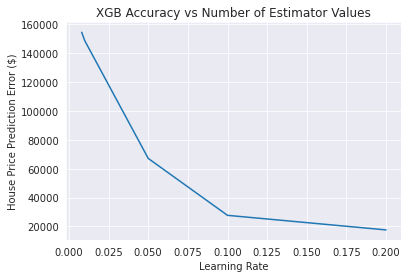

In [426]:
learn_rate_vals = [0.2, 0.1, 0.05, 0.01, 0.008]
ax_8 = sns.lineplot(x=learn_rate_vals, y=xgb_accuracy_4)
ax_8.set_title('XGB Accuracy vs Number of Estimator Values')
ax_8.set_xlabel('Learning Rate')
ax_8.set_ylabel('House Price Prediction Error ($)')

In [435]:
# change the learning rate to increase model accuracy again
xgb_model_13 = xgb.XGBRegressor(n_estimators=35, learning_rate=0.12, random_state=0)
print(test_model(xgb_model_13, preprocessor_1))

17124.89968161387
